In [1]:
import numpy as np

import matplotlib.pyplot as plt

# %matpnlotlib notebook 
%matplotlib inline 

In [10]:
import qutip as qutip

# https://qutip.readthedocs.io/en/latest/guide/guide.html
# https://qutip.org/qutip-tutorials/

fileroot = 'walk_02_'

In [3]:

# given a Hermitian operator Hop on a 2 state system
# create an tensor product n_qubit unitary that is identity except j, j+1 qubits
# were we put the operator e^(i epsilon Hop)
# does not use any globals
def mk_interaction_small(n_qubits,Hop,epsilon,j):
    if (j <0):
        print('err j<0')
        return 0
    if (j > n_qubits-2):
        print('err j<n_qubits-2')
        return 0
    small_op = 1j*epsilon*Hop  # e^(i epsilon Hop)
    U_small = small_op.expm()  # make a small near identity transformation 
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)
    op_list = np.append(op_list,U_small)
    for k in range(j+2,n_qubits):
         op_list = np.append(op_list,id2)
    U_int = qutip.tensor(op_list) 
    return U_int

if (1==0):  # testit, 
    #create a swap gate for 2 qubits 
    #|ij> \to |ji> 
    # is both hermitian and unitary 
    Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
         dims = [[2, 2], [2, 2]],
        isherm=True,
        isunitary=True)
    print(Qswap)
    epsilon=0.1
    n_qubits = 5
    U_int0 = mk_interaction_small(n_qubits,Qswap,epsilon,n_qubits-2)
    print(U_int0)
    print(U_int0.isunitary)
    

In [4]:
# make the two Kraus operators we need for a reset operation on a single qubit 
def mkKraus_reset():
    ket0 = qutip.basis(2, 0) # |0>
    ket1 = qutip.basis(2, 1) # |1>
    K0 = ket0*ket0.dag() #|0><0|
    K1 = ket0*ket1.dag() #|0><1|
    return K0,K1

# Make the 2 Kraus operators needed for a full n_qubit system
# but reseting only j-th qubit 
# uses above routine mkKraus_reset()
def mk_Kreset(n_qubits,j):
    K0,K1 = mkKraus_reset() # get the 2 1 bit kraus ops
    id2 = qutip.qeye(2)  # identity ops
    op_list0 = []
    op_list1 = []
    for k in range(0,j):
        op_list0 = np.append(op_list0,id2)  # load up identities until j index 
        op_list1 = np.append(op_list1,id2)  
    op_list0 = np.append(op_list0,K0) 
    op_list1 = np.append(op_list1,K1) 
    for k in range(j+1,n_qubits):
        op_list0 = np.append(op_list0,id2)  # load up identities until last index 
        op_list1 = np.append(op_list1,id2)  
    K0_big = qutip.tensor(op_list0)
    K1_big = qutip.tensor(op_list1)
    return K0_big,K1_big

showit = 0
if (1==showit):
    K0,K1 = mkKraus_reset()
    print(K0,K1)

if (1==showit):
    n_qubits=5
    K0_big,K1_big = mk_Kreset(n_qubits,0)
    print(K0_big,K1_big)



In [31]:
# random op on first qubit
# reset on last qubit
# in between exponentially small versions of an operator that we pass  
# calls above routines mk_Kreset(), mkKraus_reset(), mk_interaction_small()
class walkit():
    # init: arguments:
    #  n_qubits:  number of qubits
    #  epsilon:  strength of 2qubit local interaction 
    #  H_2bits:  Hermitian 2qubit interaction operator
    #  sim_label:  a string label for simulation
    def __init__(self,n_qubits,epsilon,H_2bits,sim_label):
        self.n_qubits = n_qubits  # number of qubits
        self.N = 2**n_qubits
        self.epsilon = epsilon  # perturbation parameter 
        self.H_2bits = H_2bits  # Hermitian op
        self.sim_label = sim_label  # a string label 

        # make Kraus operators for reset on last qubit 
        K0_big,K1_big = mk_Kreset(self.n_qubits,self.n_qubits-1)    # external routine 
        self.K0_big = K0_big # store the Kraus operators (n_qubit system)
        self.K1_big = K1_big 
        
        self.init_rho()  # initialize to the ground state, makes self.rho
        self.mk_int_prod()  # make an interaction unitary  self.U_int_prod  using self.epsilon and self.H_2bits

    # create density operator from ground state in all qubits 
    # creates self.rho
    def init_rho(self):
        ket0 = qutip.basis(2, 0)
        op_list = []
        for j in range(self.n_qubits):
            op_list = np.append(op_list,ket0)
        psi  = qutip.tensor(op_list) # this is a ket not an operator 
        self.rho = qutip.ket2dm(psi)  # make density operator from statevector psi
        self.rho_init = self.rho  # keep a copy
        
    # make an interaction unitary of a product of nearidentity operators based on a 2 qubit operator self.H_2bits
    # creates self.U_int_prod
    # this is a sequential product of 2qubit operators 
    def mk_int_prod(self):
        U_int_prod  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon,0) # external routine 
        # this is a n_qubit operator that has e^{i epsilon H_2bits} operating on first two qubits
        # and is identity in the rest 
        for j in range(1,self.n_qubits-1):  # from 1 to n-1
            U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon,j)    # sequential local interactions
            U_int_prod = U_int*U_int_prod   # is a product of all these interactions operators 
        self.U_int_prod = U_int_prod  # returns nothing, creates self.U_int_prod

    # first do random, then interactions, then reset, then update rho
    def do_channel(self):
        U_rand = self.create_rand_op(0) # random op in first qubit, external routine 
        # U_rand must be remade every time 
        U_tot = self.U_int_prod*U_rand  # interactions after random op 
        #print(U_tot)
        U_tot_dagger = U_tot.dag()
        new_rho = U_tot*(self.rho*U_tot_dagger)  # unitary evolution of density operator 
        # interactions and random operator applied to density operator in above line
        new_rho2  = self.K0_big*(new_rho*self.K0_big.dag()) + self.K1_big*(new_rho*self.K1_big.dag()) 
        # apply reset channel in above line
        self.rho = new_rho2  # update density operator 

    # iterate ntimes x nstore
    # store traced density operators nstore times 
    def iterate(self,ntimes,nstore):
        rho_store = np.zeros([nstore,self.n_qubits,2,2],dtype=complex)
        mx_store = np.zeros([nstore,self.n_qubits])
        my_store = np.zeros([nstore,self.n_qubits])
        mz_store = np.zeros([nstore,self.n_qubits])
        for k in range(nstore):
            for m in range(ntimes):  # iterate ntimes 
                self.do_channel()
            for j in range(self.n_qubits):
                rho_j = self.rho.ptrace(j)  # partial trace all qubits but the jth one
                rho_store[k,j,:,:] = rho_j.full()  # try to store each partial trace 
                mx = np.real( (rho_j*qutip.sigmax()).tr())  # measure x,y,z in each qubit
                my = np.real( (rho_j*qutip.sigmay()).tr())  #
                mz = np.real( (rho_j*qutip.sigmaz()).tr())
                mx_store[k,j] = mx
                my_store[k,j] = my
                mz_store[k,j] = mz
        self.rho_store = rho_store
        self.mx_store = mx_store
        self.my_store = my_store
        self.mz_store = mz_store
        self.ntimes = ntimes
        self.nstore = nstore

    # create a unitary operator that is a tensor product of identity on all qubits but the j-th one 
    # and is random Haar on the j-th one
    # indexing j=0 to n_qubits-1
    # does not use any globals
    # returned operater is a unitary on full n_qubit system
    def create_rand_op(self,j):
        id2 = qutip.qeye(2)  # identity on a single qubit 
        R2 = qutip.random_objects.rand_unitary(2)  # Haar random on 2 state  (single qubit)
        op_list = []  # create a list of operators  that is n_qubits long
        for k in range(0,j):
            op_list = np.append(op_list,id2)  # insert identities 
        op_list = np.append(op_list,R2)  # put in the random op
        for k in range(j+1,self.n_qubits):
            op_list = np.append(op_list,id2) # more identities 
        U_rand = qutip.tensor(op_list)   # tensor product of n_qubit number of 2 state systems 
        return U_rand

In [90]:
# make a 2 qubit swap operator 
Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
             dims = [[2, 2], [2, 2]],
            isherm=True,
            isunitary=True)

# controlled not with first bit the control bit 
QCnotC0 =  qutip.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
             dims = [[2, 2], [2, 2]],
            isherm=True,
            isunitary=True)
#print(QCnotC0)

# controlled not with second bit the control bit 
QCnotC1 =  qutip.Qobj([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]],
             dims = [[2, 2], [2, 2]],
            isherm=True,
            isunitary=True)

#print(QCnotC1)
#Qswap.full()

In [78]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1'
sim1 =  walkit(n_qubits,epsilon,Qswap,sim_label)
#junk1.do_channel()
mtimes = 1 
nstore = 400*8
sim1.iterate(mtimes,nstore)  # 

-2.183006049264699e-05 0.10171644083116002
0.37887104012415806 0.07604745879616302
0.47005903579410424 0.05901683478394628
0.5480077634224515 0.06301525219692203
0.6377918686226712 0.05036877521862105
0.9999999999988283 4.3465714899570303e-13
walk_02_S1_sz.png


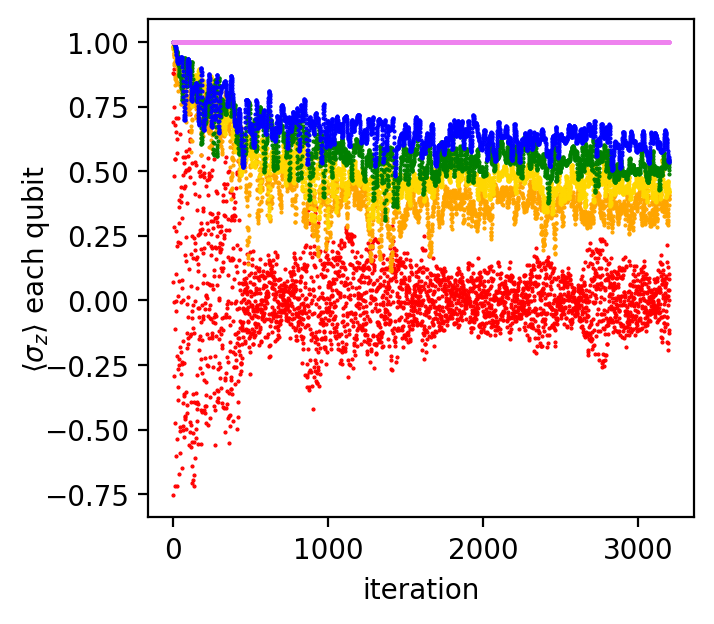

In [79]:
def sigz_fig(sim,i0):
    colorlist = ['red','orange','gold','green','blue','violet']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])
    nit = np.arange(len(mz0))
    for j in range(n_qubits):
        mz = np.squeeze(sim.mz_store[0:,j])
        print(np.mean(mz[i0:]),np.std(mz[i0:]))
        ax.plot(nit,mz,'.',color=colorlist[j%nc],ms=1)
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'$\langle \sigma_z \rangle$ each qubit',labelpad=-3)
    ofile = fileroot+sim.sim_label+'_sz.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

sigz_fig(sim1,500)

8.684051739937419e-05 0.13899668370503937
0.4136697422421096 0.09492976666594058
0.5087863261542361 0.07470914754310433
0.5678132280228344 0.0722137470253777
0.6534927451794216 0.07843452838684034
1.0000000000011082 6.922131092145735e-13
walk_02_S2_sz.png


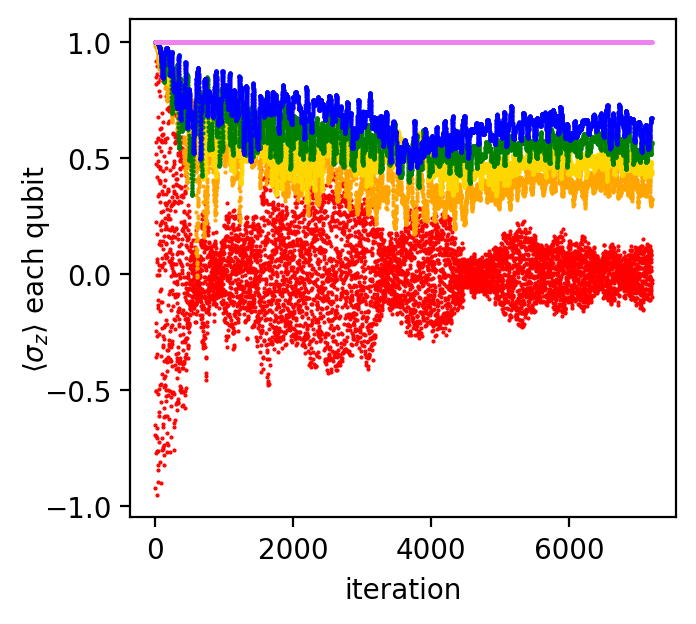

In [83]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S2'
mtimes = 1 
nstore = 400*18
sim2 =  walkit(n_qubits,epsilon,Qswap,sim_label)
sim2.iterate(mtimes,nstore)  # 
sigz_fig(sim2,500)

walk_02_S1_szmov.png


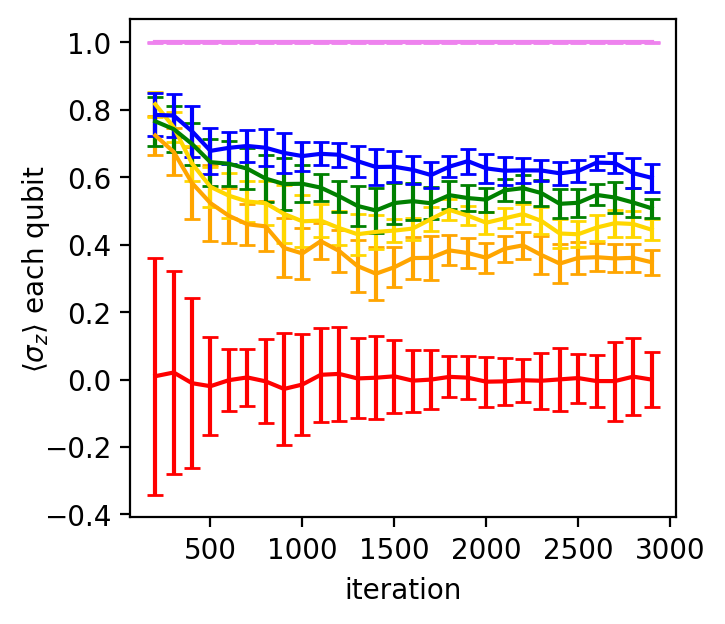

walk_02_S2_szmov.png


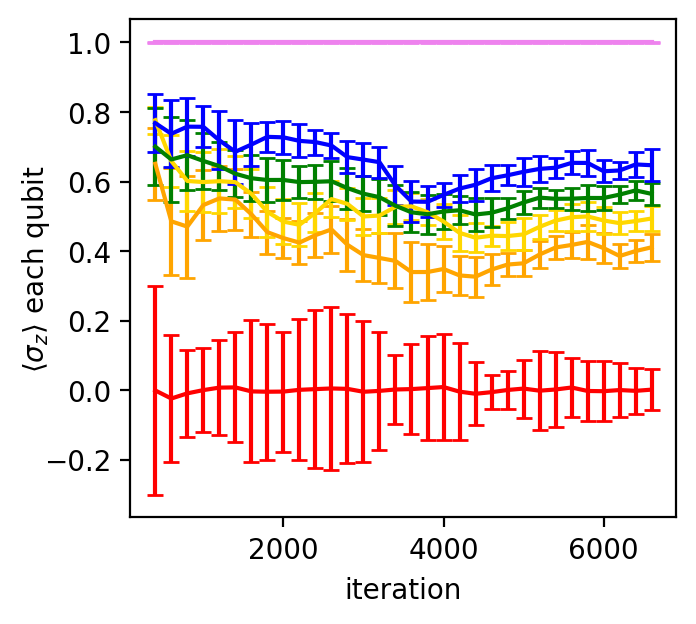

In [84]:
# series is a 1 array, d is a window length (integer)
# make a moving average of both mean and dispersion around mean
from scipy import ndimage
def stats_window(series,dwindow):
    ns = len(series)
    moving_ave = ndimage.uniform_filter(series, size=dwindow,mode='constant')
    remainder = (series - moving_ave)**2
    moving_sig2 = ndimage.uniform_filter(remainder, size=dwindow,mode='constant')
    moving_sig = np.sqrt(moving_sig2+1e-6)
    return moving_ave,moving_sig

def sigz_moving_fig(sim,dwindow):
    colorlist = ['red','orange','gold','green','blue','violet']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])
    nit = np.arange(len(mz0))
    di=int(dwindow/2)
    for j in range(n_qubits):
        mz = np.squeeze(sim.mz_store[0:,j])
        moving_ave,moving_sig = stats_window(mz,dwindow)
        #print(np.mean(mz[i0:]),np.std(mz[i0:]))
        #ax.plot(nit,mz,'.',color=colorlist[j%nc],ms=1)
        plt.errorbar(nit[2*di:-2*di:di],moving_ave[2*di:-2*di:di],yerr=moving_sig[2*di:-2*di:di],capsize=3,color=colorlist[j%nc])
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'$\langle \sigma_z \rangle$ each qubit',labelpad=-3)
    ofile = fileroot+sim.sim_label+'_szmov.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

sigz_moving_fig(sim1,200)
sigz_moving_fig(sim2,400)

-0.000541741298134637 0.07942556419433569
0.1564922961255921 0.0668332124451259
0.21282992683361546 0.06213528293086023
0.3098193117621902 0.04940061807604374
0.47723504143568285 0.060421615985332904
0.9999999999992452 2.973574737164679e-13
walk_02_S3_sz.png


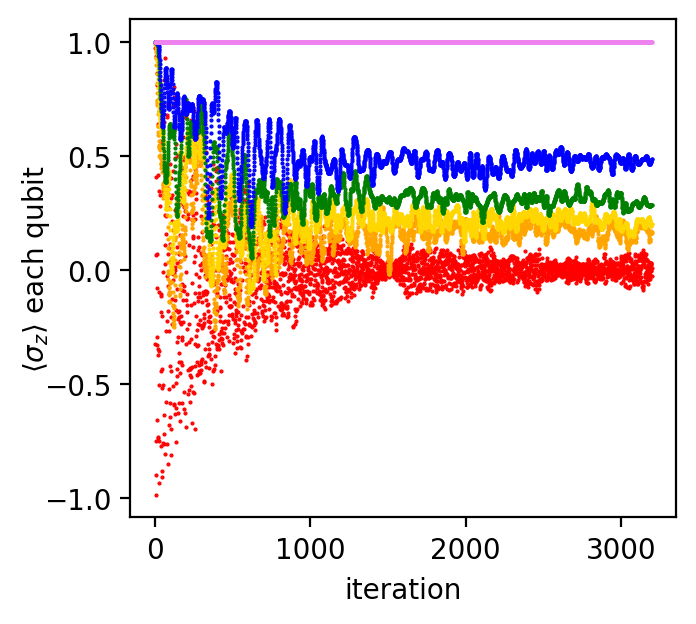

In [97]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S3'
sim3 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC0,sim_label)
#junk1.do_channel()
mtimes = 1 
nstore = 400*8
sim3.iterate(mtimes,nstore)  # 
sigz_fig(sim3,500)

-0.0010487242688019783 0.13353493620794737
0.12126001668862216 0.07300201127901934
0.16095591569958012 0.0839390490463278
0.22403591062754621 0.08079900450509968
0.33725121925559237 0.10114793978922913
0.9999999999992452 2.474093694628824e-13
walk_02_S4_sz.png


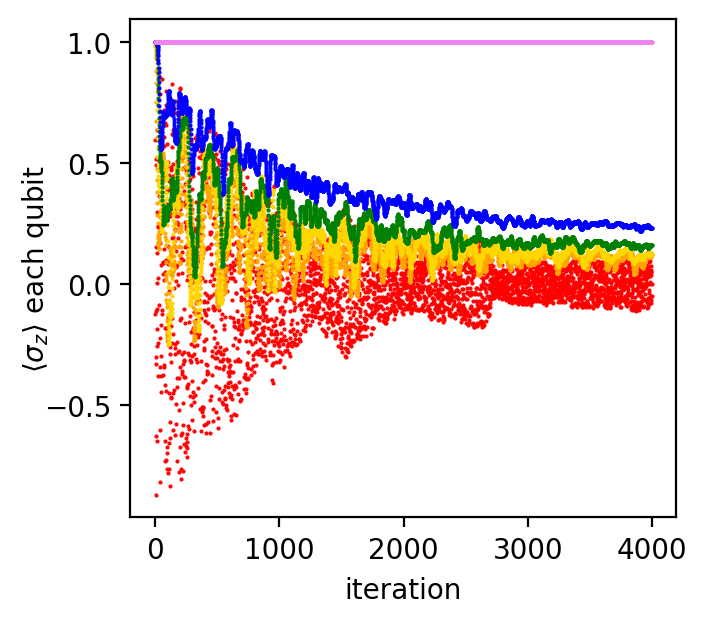

In [99]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S4'
mtimes = 1 
nstore = 400*10
sim4 =  walkit(n_qubits,epsilon,0.2*Qswap+0.8*QCnotC0,sim_label)
#junk1.do_channel()
sim4.iterate(mtimes,nstore)  # 
sigz_fig(sim4,500)

0.0025413753210890293 0.10929877904883192
0.24719639325294404 0.09194993466359443
0.22223018503679023 0.09774258424474169
0.2486478433564996 0.09533271131235502
0.38407089771013114 0.08808087078129263
0.9999999999982844 6.22635013924893e-13
walk_02_S5_sz.png


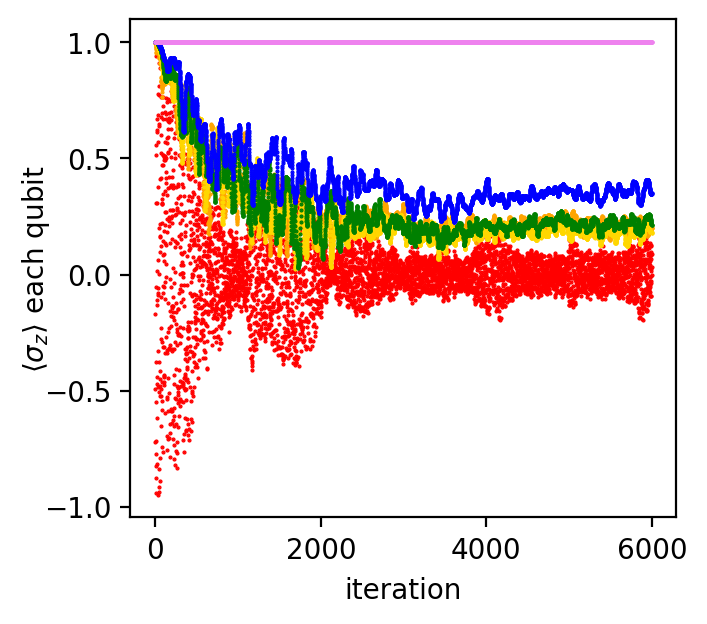

In [98]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S5'
mtimes = 1 
nstore = 400*15
sim5 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC1,sim_label)
#junk1.do_channel()
sim5.iterate(mtimes,nstore)  # 
sigz_fig(sim5,500)

0.005123322376456179 0.2138039118989578
0.5174214493515754 0.1546746111880251
0.9999999999991451 4.133303860845756e-13
walk_02_T1_sz.png


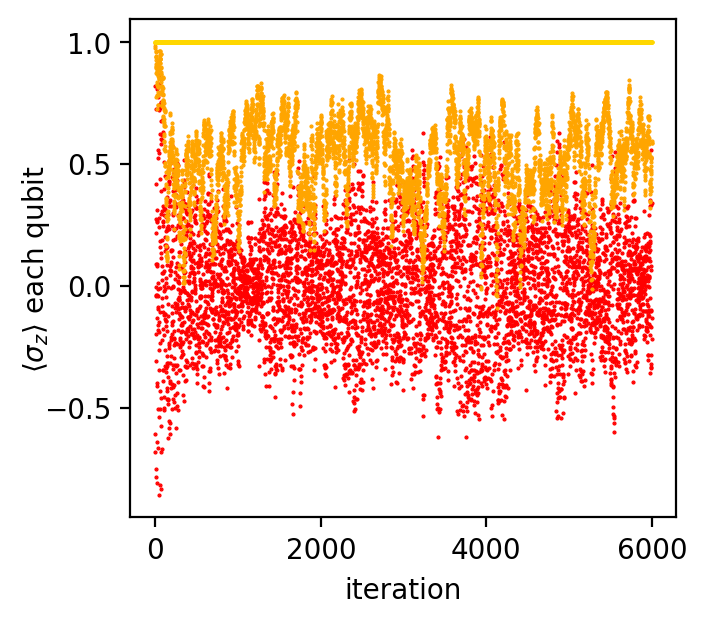

In [100]:
n_qubits = 3
epsilon = 0.1;
sim_label = 'T1'
mtimes = 1 
nstore = 400*15
tsim1 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim1.iterate(mtimes,nstore)  # 
sigz_fig(tsim1,500)

0.003918011478394358 0.26299967981925165
0.5219490537553924 0.17987863001562598
1.0000000000004126 2.2118582773026744e-13
walk_02_T2_sz.png


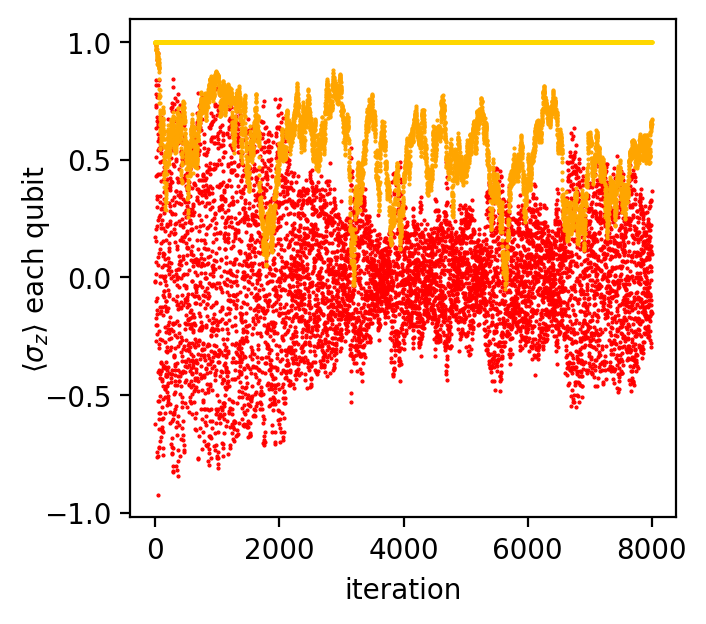

In [102]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T2'
mtimes = 1 
nstore = 400*20
tsim2 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim2.iterate(mtimes,nstore)  # 
sigz_fig(tsim2,500)

0.0009273430876544154 0.2147095125968403
0.348319143993072 0.16572754577721685
0.9999999999991364 4.3806219640886056e-13
walk_02_T3_sz.png


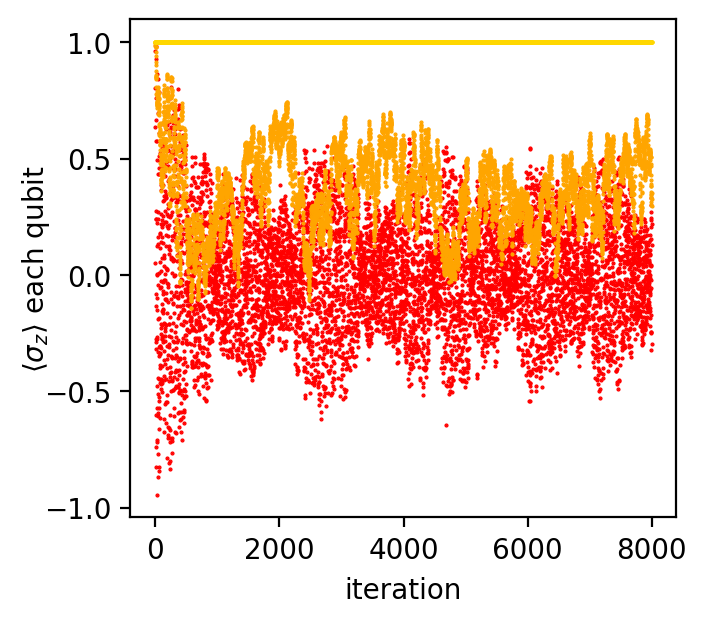

In [107]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T3'
mtimes = 1 
nstore = 400*20
tsim3 =  walkit(n_qubits,epsilon,1*Qswap+1*QCnotC0,sim_label)
tsim3.iterate(mtimes,nstore)  # 
sigz_fig(tsim3,500)